# Churn Prediction

## Introduction

Customer acquisition and retention are like the two wings of a bird: if either one is missing, then flight becomes impossible. Similarly, a company needs to both acquire and then retain customers to achieve success in the subscription world. 

This task is aimed to explain how to use customer data to help the company’s growth by applying the predictive model to better understand why and when users withdraw their money from their Robinhood account, i.e., how we can improve customer retention or lower customer churn. One of the powerful tools to enhance Retention Rate (hence the PMF) is Churn Prediction. Using this technique, you can easily find out who is likely to churn in the given period.
Here you can find the structure of this project:
- Exploratory data analysis
- Feature engineering
- Imbalance handling
- Building a classification model with XGBoost
- Feature importance
- conclusion


## Exploratory Data Analysis

We start by checking out how our data looks like. Let’s start by importing our data and print the first ten rows of the feature data.

In [566]:
import pandas as pd
features_data = pd.read_csv('features_data.csv')
features_data.head(10)

,risk_tolerance,investment_experience,liquidity_needs,platform,time_spent,instrument_type_first_traded,first_deposit_amount,time_horizon,user_id
0,high_risk_tolerance,limited_investment_exp,very_important_liq_need,Android,33.129417,stock,40.0,med_time_horizon,895044c23edc821881e87da749c01034
1,med_risk_tolerance,limited_investment_exp,very_important_liq_need,Android,16.573517,stock,200.0,short_time_horizon,458b1d95441ced242949deefe8e4b638
2,med_risk_tolerance,limited_investment_exp,very_important_liq_need,iOS,10.008367,stock,25.0,long_time_horizon,c7936f653d293479e034865db9bb932f
3,med_risk_tolerance,limited_investment_exp,very_important_liq_need,Android,1.031633,stock,100.0,short_time_horizon,b255d4bd6c9ba194d3a350b3e76c6393
4,high_risk_tolerance,limited_investment_exp,very_important_liq_need,Android,8.187250,stock,20.0,long_time_horizon,4a168225e89375b8de605cbc0977ae91
5,med_risk_tolerance,no_investment_exp,not_important_liq_need,iOS,12.968117,stock,100.0,med_time_horizon,0322b1d744cc89ebbe6ebe70d824d922
6,low_risk_tolerance,good_investment_exp,very_important_liq_need,Android,30.710083,stock,5.0,long_time_horizon,f4cac8c1544b723ddedc9bdba81c64c0
7,high_risk_tolerance,good_investment_exp,somewhat_important_liq_need,iOS,0.000000,stock,100.0,short_time_horizon,bdc39d2fc664ef9a5e6713168057f892
8,high_risk_tolerance,good_investment_exp,very_important_liq_need,iOS,0.000000,stock,5000.0,short_time_horizon,85f2f0f54411b4f3e7a403ba902e7280
9,med_risk_tolerance,no_investment_exp,very_important_liq_need,Android,2.969617,stock,11.0,med_time_horizon,529ddd19dac72d55cde8e633340a9aed


In [567]:
features_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5584 entries, 0 to 5583
Data columns (total 9 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   risk_tolerance                5584 non-null   object 
 1   investment_experience         5584 non-null   object 
 2   liquidity_needs               5584 non-null   object 
 3   platform                      5584 non-null   object 
 4   time_spent                    5584 non-null   float64
 5   instrument_type_first_traded  5584 non-null   object 
 6   first_deposit_amount          5584 non-null   float64
 7   time_horizon                  5584 non-null   object 
 8   user_id                       5584 non-null   object 
dtypes: float64(2), object(7)
memory usage: 392.8+ KB


In [568]:
features_data.describe()

,time_spent,first_deposit_amount
count,5584.000000,5584.000000
mean,34.509706,633.566805
std,155.080551,2118.323263
min,0.000000,0.000000
25%,2.848908,50.000000
50%,13.474708,100.000000
75%,33.823829,500.000000
max,8788.329450,50000.000000


It seems like our data fall under two categories:\
**Categorical features**: risk_tolerance, investment_experience, liquidity_needs,platform, instrument_type_first_traded, time_horizon\
**Numerical features**: first_deposit_amount, time_spent

Now lets work with Equity_value_data.

In [402]:
equity_value_data = pd.read_csv('equity_value_data.csv')
equity_value_data["timestamp"]=pd.to_datetime(equity_value_data["timestamp"]).dt.date
equity_value_data.sort_values(by=['timestamp', 'user_id'])
equity_value_data.head(10)

,timestamp,close_equity,user_id
0,2016-11-16,48.16,bcef4fa9b0bdf22bcf7deae708decf03
1,2016-11-17,48.16,bcef4fa9b0bdf22bcf7deae708decf03
2,2016-11-18,48.16,bcef4fa9b0bdf22bcf7deae708decf03
3,2016-11-21,48.16,bcef4fa9b0bdf22bcf7deae708decf03
4,2016-11-22,48.16,bcef4fa9b0bdf22bcf7deae708decf03
5,2016-11-23,48.16,bcef4fa9b0bdf22bcf7deae708decf03
6,2016-11-25,48.16,bcef4fa9b0bdf22bcf7deae708decf03
7,2016-11-28,48.16,bcef4fa9b0bdf22bcf7deae708decf03
8,2016-11-29,48.16,bcef4fa9b0bdf22bcf7deae708decf03
9,2016-11-30,48.16,bcef4fa9b0bdf22bcf7deae708decf03


We need to find the users that their equity value falls less than \\$ 10 for a period of 28 consecutive calendar days or longer. In this dataset, timestamps of days that users equity is greater than \\$ 10 are available. 
So let's find the difference between the consecutive timestamps for each user, then we can find churned users and label them. 

In [403]:
equity_value_data['timestamp_shifted'] = equity_value_data.groupby(['user_id'])['timestamp'].transform('shift')
equity_value_data['low10days']= equity_value_data['timestamp']-equity_value_data['timestamp_shifted']
equity_value_data=equity_value_data.dropna()
equity_value_data['low10days']=equity_value_data['low10days'].dt.days.astype('int16')
equity_value_data

,timestamp,close_equity,user_id,timestamp_shifted,low10days
1,2016-11-17,48.16,bcef4fa9b0bdf22bcf7deae708decf03,2016-11-16,1
2,2016-11-18,48.16,bcef4fa9b0bdf22bcf7deae708decf03,2016-11-17,1
3,2016-11-21,48.16,bcef4fa9b0bdf22bcf7deae708decf03,2016-11-18,3
4,2016-11-22,48.16,bcef4fa9b0bdf22bcf7deae708decf03,2016-11-21,1
5,2016-11-23,48.16,bcef4fa9b0bdf22bcf7deae708decf03,2016-11-22,1
...,...,...,...,...,...
1119153,2017-08-14,2270.71,98580360c4fb5b0ec511cd87f0d429ed,2017-08-11,3
1119154,2017-08-15,2275.02,98580360c4fb5b0ec511cd87f0d429ed,2017-08-14,1
1119155,2017-08-16,2282.03,98580360c4fb5b0ec511cd87f0d429ed,2017-08-15,1
1119156,2017-08-17,2237.45,98580360c4fb5b0ec511cd87f0d429ed,2017-08-16,1


Now let's find the churned users who have less than \\$10 for 28 consecutive days.
Also, here we extract the mean value of the user's equity to add to the current features. 
This new feature can help to improve the prediction model.

In [555]:
churn_data = equity_value_data.groupby(['user_id'], as_index=False)['low10days'].max()
churn_data['churned']= churn_data['low10days'].apply(lambda x: 1 if x >= 28 else 0)
equity = equity_value_data.groupby(['user_id'], as_index=False)['close_equity'].mean()
churn_data = pd.merge(churn_data,equity, on=['user_id'])
churn_data

,user_id,low10days,churned,close_equity
0,0012db34aa7b083f5714e7831195e54d,4,0,606.700158
1,001d6c77dbdb3213cead7673f250bfdc,4,0,3309.334904
2,002e4653171ddc61c3cd30603cd7bd3e,4,0,117.339213
3,00384fa9be6fdca1b786bae70d78f88f,4,0,462.435732
4,0042aac295a0d4df88f4b83012778bd4,4,0,1566.794152
...,...,...,...,...
5575,ff9ee08791e20724a86995ab2bc72578,4,0,91.909094
5576,ffa12d2f97e310910291f9b26fb2318d,4,0,6077.407830
5577,ffae713096867a32e74f633060667153,4,0,20.168431
5578,ffbda9a14e07718e2b21fb03896d21c5,4,0,340.237191


How many of the users churned during this period??

In [412]:
churn_data.user_id[churn_data.churned==1].count()

279

Let's take a look at our dataset after merging with the extracted features

In [577]:
df_data= pd.merge(features_data,churn_data, on=['user_id'])
df_data = df_data[['risk_tolerance','investment_experience','liquidity_needs','platform','time_spent','instrument_type_first_traded','first_deposit_amount','time_horizon','close_equity', 'churned']]
df_data

,risk_tolerance,investment_experience,liquidity_needs,platform,time_spent,instrument_type_first_traded,first_deposit_amount,time_horizon,close_equity,churned
0,high_risk_tolerance,limited_investment_exp,very_important_liq_need,Android,33.129417,stock,40.0,med_time_horizon,77.322222,0
1,med_risk_tolerance,limited_investment_exp,very_important_liq_need,Android,16.573517,stock,200.0,short_time_horizon,351.527291,0
2,med_risk_tolerance,limited_investment_exp,very_important_liq_need,iOS,10.008367,stock,25.0,long_time_horizon,49.240000,0
3,med_risk_tolerance,limited_investment_exp,very_important_liq_need,Android,1.031633,stock,100.0,short_time_horizon,186.627746,0
4,high_risk_tolerance,limited_investment_exp,very_important_liq_need,Android,8.187250,stock,20.0,long_time_horizon,209.343378,0
...,...,...,...,...,...,...,...,...,...,...
5575,high_risk_tolerance,limited_investment_exp,very_important_liq_need,Android,8.339283,stock,300.0,long_time_horizon,2744.063890,0
5576,med_risk_tolerance,limited_investment_exp,somewhat_important_liq_need,iOS,7.241383,stock,100.0,short_time_horizon,311.105633,1
5577,med_risk_tolerance,no_investment_exp,very_important_liq_need,both,22.967167,stock,50.0,short_time_horizon,116.519087,0
5578,med_risk_tolerance,limited_investment_exp,somewhat_important_liq_need,iOS,10.338417,stock,100.0,long_time_horizon,331.846893,0


In [414]:
df_data['churned'].mean()*100

5.0

In [578]:
import plotly.graph_objects as go
import plotly.offline as pyoff
df_plot = df_data.groupby('churned').count().reset_index()
plot_data = [
    go.Bar(
        x=df_plot['churned'],
        y=df_plot['time_spent'],
        width = [0.5, 0.5],
        marker=dict(
        color=['green', 'blue'])
    )
]
plot_layout = go.Layout(
        xaxis={"type": "category"},
        yaxis={"title": "Churn Rate"},
        title='churned',
        plot_bgcolor  = 'rgb(243,243,243)',
        paper_bgcolor  = 'rgb(243,243,243)',
    )
fig1 = go.Figure(data=plot_data,layout=plot_layout)
pyoff.iplot(fig1)

Very Unbalance Data. We have to take care of that later

Starting from the categorical ones, we shed light on all features and see how helpful they are to identify if a customer will churn.

### Risk tolerance

By using the code block below, we easily visualize how Churn Rate looks like for each risk_tolerance factor:

In [579]:
import plotly.graph_objects as go
import plotly.offline as pyoff

df_plot = df_data.groupby('risk_tolerance').churned.mean().reset_index()

plot_data = [
    go.Bar(
        x=df_plot['risk_tolerance'],
        y=df_plot['churned']*100,
        width = [0.5, 0.5,0.5],
        marker=dict(
        color=['green', 'blue', 'black'])
    )
]
plot_layout = go.Layout(
        xaxis={"type": "category"},
        yaxis={"title": "Churn Rate"},
        title='risk_tolerance',
        plot_bgcolor  = 'rgb(243,243,243)',
        paper_bgcolor  = 'rgb(243,243,243)',
    )
fig1 = go.Figure(data=plot_data,layout=plot_layout)
pyoff.iplot(fig1)

risk tolerance breakdown for the churn rate:

In [580]:
df_data.groupby('risk_tolerance').churned.mean()*100

risk_tolerance
high_risk_tolerance     3.929273
low_risk_tolerance     11.297071
med_risk_tolerance      6.299213
Name: churned, dtype: float64

Low_risk_tolerance customers are more likely to churn rather than med_risk_tolerance and high_risk_tolerance customers. 

Let’s replicate this for all categorical columns.
Now we go over the features which show the most significant difference across their values:

### Investment Experience

Investment experience is an essential factor in customer retention rate and churn rate. High experienced customers usually retain with the platform and keep investing in the market for the long term. 

In [417]:
df_plot = df_data.groupby('investment_experience').churned.mean().reset_index()
plot_data = [
    go.Bar(
        x=df_plot['investment_experience'],
        y=df_plot['churned']*100,
        width = [0.5, 0.5,0.5,0.5],
        marker=dict(
        color=['green', 'blue', 'black', 'red'])
    )
]
plot_layout = go.Layout(
        xaxis={"type": "category"},
        yaxis={"title": "Churn Rate"},
        title='investment_experience',
        plot_bgcolor  = 'rgb(243,243,243)',
        paper_bgcolor  = 'rgb(243,243,243)',
    )
fig1 = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig1)

In [418]:
df_data.groupby('investment_experience').churned.mean()*100

investment_experience
extensive_investment_exp    3.947368
good_investment_exp         4.409171
limited_investment_exp      5.128205
no_investment_exp           5.233853
Name: churned, dtype: float64

As expected, customers with no or limited investment experience tend to churn compared to the customers with excellent and extensive investment experience.

For the rest of the categorical features, the mean churn rate is presented. 

### liquidity needs

In [419]:
df_data.groupby('liquidity_needs').churned.mean()*100

liquidity_needs
not_important_liq_need         6.201550
somewhat_important_liq_need    5.415162
very_important_liq_need        4.817276
Name: churned, dtype: float64

Customers that have high liquidity needs are less likely to churn. On the other hand, customers with no or less liquidity need are more likely to churn. 

### platform

In [420]:
df_data.groupby('platform').churned.mean()*100

platform
Android    5.239031
both       7.326733
iOS        4.565953
Name: churned, dtype: float64

Interestingly, Android users are more likely to churn, and retaining the ios users are more likely. 

### instrument_type_first_traded

In [421]:
df_data.groupby('instrument_type_first_traded').churned.mean()*100

instrument_type_first_traded
0            7.692308
adr          4.568528
cef          5.000000
etp          4.960836
lp          12.500000
mlp          5.454545
reit         1.818182
rlt          0.000000
stock        5.017624
tracking     0.000000
wrt         12.500000
Name: churned, dtype: float64

To see the trend between the average amount of time spent on the app for churned and not churned customers, let’s build a plot:

In [423]:
df_plot = df_data.groupby('churned').time_spent.mean().reset_index()
plot_data = [
    go.Bar(
        x=df_plot['churned'],
        y=df_plot['time_spent']*100,
        width = [0.2, 0.2],
        marker=dict(
        color=['green', 'blue'])
    )
]
plot_layout = go.Layout(
        xaxis={"type": "category", },
        yaxis={"title": "time_spent"},
        title='time_spent',
        plot_bgcolor  = 'rgb(243,243,243)',
        paper_bgcolor  = 'rgb(243,243,243)',
    )
fig1 = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig1)


In [424]:
df_plot = df_data.groupby('churned').first_deposit_amount.mean().reset_index()
plot_data = [
    go.Bar(
        x=df_plot['churned'],
        y=df_plot['first_deposit_amount']*100,
        width = [0.2, 0.2],
        marker=dict(
        color=['green', 'blue'])
    )
]
plot_layout = go.Layout(
        xaxis={"type": "category", },
        yaxis={"title": "first_deposit_amount"},
        title='first_deposit_amount',
        plot_bgcolor  = 'rgb(243,243,243)',
        paper_bgcolor  = 'rgb(243,243,243)',
    )
fig1 = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig1)

In [425]:
df_plot = df_data.groupby('churned').close_equity.mean().reset_index()
plot_data = [
    go.Bar(
        x=df_plot['churned'],
        y=df_plot['close_equity']*100,
        width = [0.2, 0.2],
        marker=dict(
        color=['green', 'blue'])
    )
]
plot_layout = go.Layout(
        xaxis={"type": "category", },
        yaxis={"title": "close_equity"},
        title='close_equity',
        plot_bgcolor  = 'rgb(243,243,243)',
        paper_bgcolor  = 'rgb(243,243,243)',
    )
fig1 = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig1)

customers who churned on average spent 3166 s on the app and invested 36 k; on the other hand, customers who did not churn spent 3466 s and invested 65 k on average.: 

## Feature Engineering
In this section, we are going to transform our raw features to extract more information from them. Our strategy is as follows:
1- Apply Label Encoder to categorical features which are binary\
2- Apply get_dummies() to categorical features which have multiple values\
3- Center Scale the continous variables

In [536]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

dummy_columns = [] 

for column in df_data.columns:
    if df_data[column].dtype == object and column != 'churned':
        if df_data[column].nunique() == 2:
            #apply Label Encoder for binary ones
            df_data[column] = le.fit_transform(df_data[column]) 
        else:
            dummy_columns.append(column)

df_data = pd.get_dummies(data = df_data,columns = dummy_columns)
df_data

,time_spent,first_deposit_amount,close_equity,churned,risk_tolerance_high_risk_tolerance,risk_tolerance_low_risk_tolerance,risk_tolerance_med_risk_tolerance,investment_experience_extensive_investment_exp,investment_experience_good_investment_exp,investment_experience_limited_investment_exp,...,instrument_type_first_traded_lp,instrument_type_first_traded_mlp,instrument_type_first_traded_reit,instrument_type_first_traded_rlt,instrument_type_first_traded_stock,instrument_type_first_traded_tracking,instrument_type_first_traded_wrt,time_horizon_long_time_horizon,time_horizon_med_time_horizon,time_horizon_short_time_horizon
0,33.129417,40.0,77.322222,0,1,0,0,0,0,1,...,0,0,0,0,1,0,0,0,1,0
1,16.573517,200.0,351.527291,0,0,0,1,0,0,1,...,0,0,0,0,1,0,0,0,0,1
2,10.008367,25.0,49.240000,0,0,0,1,0,0,1,...,0,0,0,0,1,0,0,1,0,0
3,1.031633,100.0,186.627746,0,0,0,1,0,0,1,...,0,0,0,0,1,0,0,0,0,1
4,8.187250,20.0,209.343378,0,1,0,0,0,0,1,...,0,0,0,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5575,8.339283,300.0,2744.063890,0,1,0,0,0,0,1,...,0,0,0,0,1,0,0,1,0,0
5576,7.241383,100.0,311.105633,1,0,0,1,0,0,1,...,0,0,0,0,1,0,0,0,0,1
5577,22.967167,50.0,116.519087,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,1
5578,10.338417,100.0,331.846893,0,0,0,1,0,0,1,...,0,0,0,0,1,0,0,1,0,0


After transforming the variables, the new dataset has 31 features

In [538]:
df_data.shape

(5580, 31)

Center Scale the continous variables

In [ ]:
from sklearn import preprocessing
X = df_data.drop(['churned'],axis=1)
y = df_data.churned

X = X.to_numpy().astype(np.float)
scaler = preprocessing.StandardScaler()
X = scaler.fit_transform(X)

## Imbalance handeling

Customer churn is often a rare event in service industries but of great interest and great value. Data imbalance can drastically affect model performance. Then different methods of imbalance handling were used. Such as upsampling, SMOTE, and ADASYN.
The best algorithm was over_sampling through SMOTE. Note that we balance the training data and we keep the test data inbalance to get the performance of the model on the real test dataset. 

80 percent of the data were randomly selected for traning nad 20% were used for testing. 

In [ ]:
#train and test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=56)

applying SMOTE on the traning data

In [ ]:
from imblearn.over_sampling import SMOTE 

sm = SMOTE(random_state = 2) 
X_train_res, y_train_res = sm.fit_sample(X_train, y_train.ravel()) 

In [542]:
print("Number of datasets before SMOTE : ",y_train.shape )
print("Ratio of churened labeles before SMOTE : ",y_train.mean()*100, "%")
print("Number of datasets before SMOTE : ",y_train_res.shape)
print("Ratio of churened labeles after SMOTE : ",y_train_res.mean()*100, "%")


Number of datasets before SMOTE :  (4464,)
Ratio of churened labeles before SMOTE :  4.68189964157706 %
Number of datasets before SMOTE :  (8510,)
Ratio of churened labeles after SMOTE :  50.0 %


## Building a classification model with XGBoost

Several models were tested, SVM, logistic regression, random forest. The best model with good performance was the XGboost model. 
The cross-validation was used for the evaluation of the model and tunning the hyperparameters.
The area under the ROC curve was chosen as a metric for assessing the model. 

In [544]:

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split

params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'max_depth': [3, 4, 5]
        }

xgb = XGBClassifier(learning_rate=0.02, n_estimators=60, objective='binary:logistic', silent=True, nthread=1)


grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=params,
    scoring = 'roc_auc',
    n_jobs = 10,
    cv = 5,
    verbose=True
)

grid_search.fit(X_train_res, y_train_res)

Fitting 5 folds for each of 45 candidates, totalling 225 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    6.9s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:   25.6s
[Parallel(n_jobs=10)]: Done 225 out of 225 | elapsed:   30.7s finished


GridSearchCV(cv=5,
             estimator=XGBClassifier(learning_rate=0.02, n_estimators=60,
                                     nthread=1, silent=True),
             n_jobs=10,
             param_grid={'gamma': [0.5, 1, 1.5, 2, 5], 'max_depth': [3, 4, 5],
                         'min_child_weight': [1, 5, 10]},
             scoring='roc_auc', verbose=True)

In [548]:
grid_search.best_score_

0.9231550356876059

The amount of roc_auc on the traning dataset is 0.92. This is a very good classifier. But lets check the model with the test dataset. 

## Testing the model

In [556]:
FinalXGBmodel = XGBClassifier(n_estimators=60, learning_rate=0.02, objective='binary:logistic', max_depth=5, gamma=1.5,min_child_weight= 1) 
FinalXGBmodel.fit(X_train_res, y_train_res.ravel()) 
predictions = FinalXGBmodel.predict(X_test) 
  
# print classification report 
print(classification_report(y_test, predictions))
print('ROCAUC score:',roc_auc_score(y_test, predictions))
print('Accuracy score:',accuracy_score(y_test, predictions))
print('F1 score:',f1_score(y_test, predictions))

              precision    recall  f1-score   support

           0       0.95      0.81      0.87      1046
           1       0.11      0.36      0.17        70

    accuracy                           0.78      1116
   macro avg       0.53      0.58      0.52      1116
weighted avg       0.90      0.78      0.83      1116

ROCAUC score: 0.583447145588637
Accuracy score: 0.7813620071684588
F1 score: 0.17006802721088438


Considering the severity of the imbalanced data, the model shows an acceptable performance. For class 1 (churned users) model achieves 0.11 precision and 0.36 recall. Precision tells us how many churned users did our classifier predicted correctly. On the other side, recall tell us how many churned users it missed. AUCROC is about 0.6, which needs more work. 

We can interpret the report above as if our model tells us, 100 customers will churn, 11 of it will churn (0.67 precision). And actually, there are around 277 customers who will churn (0.45 recall). Especially recall is the main problem here, and we can improve our model’s overall performance by:
- Adding more data
- Adding more features
- More feature engineering
- Trying other models
- Hyper-parameter tuning
Moving forward, let’s see how our model works in detail. First off, we want to know which features our model is exactly used from the dataset. Also, which were the most important ones? 

## Feature importance

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

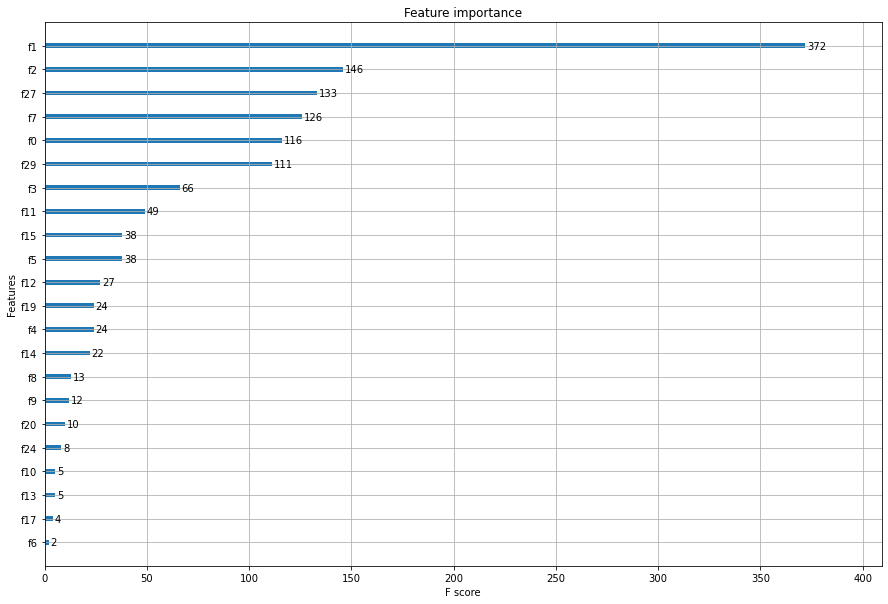

In [563]:
from xgboost import plot_importance
fig, ax = plt.subplots(figsize=(15,10))
plot_importance(FinalXGBmodel, ax=ax)

You can see that features are automatically named according to their index in the input array (X) from F0 to F31.

Manually mapping these indices to names in the dataset, we can see that our model assigned more importance to close_equity and first_deposit_amount compared to others.
